#Assignment 3: Introduction

**Veronica Pratt, Jason Reeves, George Carson**

Welcome to assignment 3, where we will analyze the light, flares, and sunspots from the eclipsing binary CM Draconis.

Together, we will walk you through our code as we discuss, process, and analyze all the data coming from this star system!

To begin, we will first of course import all the relevant packages we'll need.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.stats import t as student_t
import scipy.optimize
from astropy.timeseries import LombScargle
import scipy.signal as sc
import sqlite3

In [ ]:

# updating matplotlib parameters to make our plots look nicer
plt.rcParams.update({
        "font.size": 10,
        "mathtext.fontset": 'stix',
        "font.family": "serif", })

##Importing our Data

Next, after importing our relevant packages, we'll import all of our data from .csv files.

When importing data from .csv files, we used the genfromtxt() method in numpy, that takes in a file and, given a few parameters but in this case just the delimiter that divides the columns in the file, returns a numpy array matching the row and column number!

Common errors you might encounter when loading files into a jupyter notebook include the "FileNotFoundError," which indicates that the file path you specified does not lead to the file you want to load. Always be sure that your path includes any nested folders or directories!

In [ ]:
# Load in lightcurve as multidimensional numpy array
lightcurve = np.genfromtxt('lightcurve.csv',delimiter=',')
# Sort the array by column to select the times, fluxes, and
# errors associated with each other
lc_time = lightcurve[:,0]
lc_flux = lightcurve[:,1]
lc_err = lightcurve[:,2]

In [ ]:
# Load in spot flux curve as multidimensional numpy array
spots = np.genfromtxt('spot_modulation.csv',delimiter=',')
spots_time = spots[:,0]
spots_flux = spots[:,1]

In [ ]:
# Load in flare data as multidimensional numpy array
flare_table = np.genfromtxt('flare_table.csv',delimiter=',')
flare_index = flare_table[:,0] # A unique ID per flare
flare_time = flare_table[:,1] # The time where the peak of the flare occurs.
flare_amp = flare_table[:,2] # The amplitude of the flare (in relative flux units, e.g. an amplitude of 1.1 means the binary as a whole got 10% brighter)
flare_energy = flare_table[:,3] # The total energy of the flare, in erg.

## Looking at our Data

The first set of data we read in was the light curve of CM Draconis. This shows the flux of the the eclipsing binary over time. The top left figure below shows the full light curve, with the large vertical sections corresponding with the primary and secondary eclipses that happen over the ~1.628 day orbital period.

If we zoom in to the light curve like in the bottom left plot, we can see sinusoidal modulation, which are caused by the active regions on the rotating stellar surface.

Using the second set of data we can look at the active regions in ab it more detail. The plots on the right side focus on the spots in these active regions. We plot the spot flux over time and show a zoomed in plot to get a better look at how the spots evolve over time.

(2000.0, 2030.0)

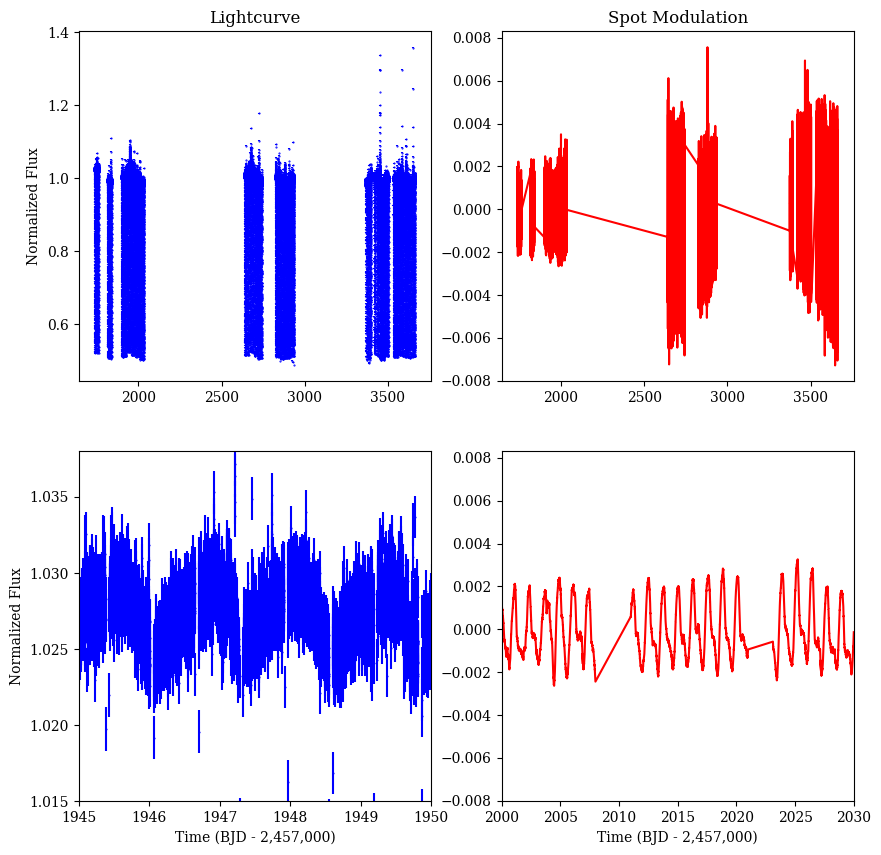

In [ ]:
# plot four subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# plot the lightcurve
axs[0, 0].errorbar(lc_time, lc_flux, yerr = lc_err, fmt='.', markersize=1,color='blue')
axs[0, 0].set_title('Lightcurve')
#axs[0, 0].set_xlabel('Time (BJD - 2,457,000)')
axs[0, 0].set_ylabel('Normalized Flux')

# plot the spot modulation
axs[0, 1].plot(spots_time, spots_flux, color='red')
axs[0, 1].set_title('Spot Modulation')
#axs[0, 1].set_xlabel('Time (BJD - 2,457,000)')

# zoom in on lightcurve
axs[1, 0].errorbar(lc_time, lc_flux, yerr = lc_err, fmt='.', markersize=1,color='blue')
axs[1, 0].set_xlabel('Time (BJD - 2,457,000)')
axs[1, 0].set_ylabel('Normalized Flux')
axs[1, 0].set_xlim([1945,1950])
axs[1, 0].set_ylim([1.015,1.038])

# zoom in on the spot modulation
axs[1, 1].plot(spots_time, spots_flux, color='red')
axs[1, 1].set_xlabel('Time (BJD - 2,457,000)')
axs[1, 1].set_xlim([2000,2030])

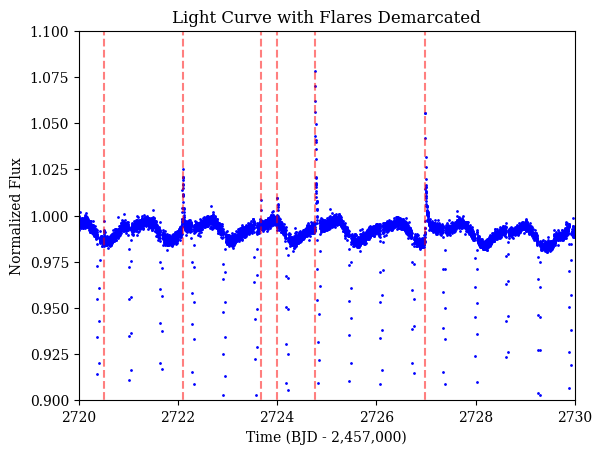

In [ ]:
# plot the flare times on the lightcurve
fig = plt.figure()
plt.scatter(lc_time, lc_flux,s=1,color='blue',zorder=1)
for ii in range(0,len(flare_table)): # Loop over each flare
    plt.plot([flare_time[ii],flare_time[ii]],[0,2],'r--',alpha=0.5)
plt.xlabel('Time (BJD - 2,457,000)')
plt.ylabel('Normalized Flux')
plt.title('Light Curve with Flares Demarcated')
plt.xlim([2720,2730])
# we are zooming in on the y-axis to highlight the flares and spot modulation,
# thus cutting out the eclipses
plt.ylim([0.9,1.1])
plt.show()

### What is a light curve?

The light curve data we have shows the amount of flux from CM Draconis -- in this case flux is equivalent to the amount of photons passing through a given camera/telescope, at different points in the observation time. You can see the drops from the eclipses, the minute spot modulation on the surface, and the flares all appear on the light curve, as it shows all the light, and the light changes, coming from the eclipsing binary.

To summarize: the light curve that we will be analyzing in this notebook shows the overall flux coming from CM Draconis, including eclipses, flares, and light from the stellar spots.

### What is the spot modulation flux? How do we analyze flares?

The spot modulation flux data we have is a model of the actual spot modulation on the surface of the two stars, with eclipses and instrumental effects accounted for, as those would confuse the signal. Thus, we are able to plot just the spot flux across time. We can see that, in our red-colored plots above, the spot modulation flux oscillates around 0. That normalization at 0 is to indicate whether the spots are, on average, brightening the stellar surfaces from their baseline or dimming them.

The spot modulation fluxes do not include any flares, so in order to investigate the flare impact on the stellar surfaces, we need to look at the flare times, in the flare_time array, amplitudes, in the flare_amp array, energies, in the flare_amp array, and the overall lightcurve. The plot directly above shows how we can use the flare_time array to mark out all the points on the light curve that have a flare.

## Understanding the Eclipsing Binary CM Draconis

CM Draconis is an eclipsing binary system considering of 2 incredibly similar M dwarf stars.

From Table 1 of Martin et. al. 2024, we can note the key properties of the CM Draconis system. All the values listed below are approximations from the table.

*   Mass of Primary: 0.225 Solar Masses
*   Mass of Secondary: 0.210 Solar Masses
*   Radius of Primary Star: 0.237 Solar Radii
*   Radius of Secondary Star: 0.237 Solar Radii
*   Semimajor Axis of Binary System: 0.0174 AU
*   Period: 1.27 days
*   Eccentricity: 0.005
*   Inclination: 89.8 degrees
*   Impact Parameter: 0.12

From these properties we can understand why CM Draconis is such a good binary system to analyze. The inlcination being near 90 degrees means that these two stars are well-aligned, so we should be seeing a primary and secondary eclipse across every orbit. The low eccentricity means the orbit is almost circular, so the time between a primary and secondary eclipse should be roughly equivalent. Additionally, the impact parameter being close to 0 means that the secondary star passes in front of the primary star nearly exactly at the primary's equator.

Additionally, the two stars have nearly identical radii, so primary and secondary eclipses should both result in near-perfect occultation. Similarly, because they are nearly identical in mass, we can accurately measure each independent mass as it is a double-lined spectroscopic binary (we can see emission from both due to the Doppler effect at different times).

One interesting fact about CM Draconis is that it's actually a triple star system, creating a super fun three-body problem. Actually, the third body does not lead to any substantial perturbation of the binary pair's rotation, as the bound white dwarf is more than 370 AU away from the primary and secondary stars. Currently, no planets have been discovered around CM Draconis, making it a great system to study an exclusive eclipsing binary pair, since many M dwarfs have planets around them.

### An Aside on M-Dwarfs

M dwarfs, a term synonymous with red dwarfs, are very-low-mass stars, and as such they have low pressures and low temperatures (making them appear red to us here on Earth). These M dwarfs would be classified as M4.5 spectral types, since their solar masses are around .22. These dwarfs are the most common type of star that's capable of fusion, but are generally difficult to observe because of their small mass, which gives them low luminosities.

M dwarfs, unlike white dwarfs, are not byproducts from the final evolutionary stage of other stars. Rather, M dwarfs form along the main sequence (see HR diagram of Main Sequence below), hence why they're so common, as the stellar IMF shows that the less massive a star, the more common it is. M dwarfs also have a long lifespan thanks to their low mass, making them more common as well since they last for a long time.

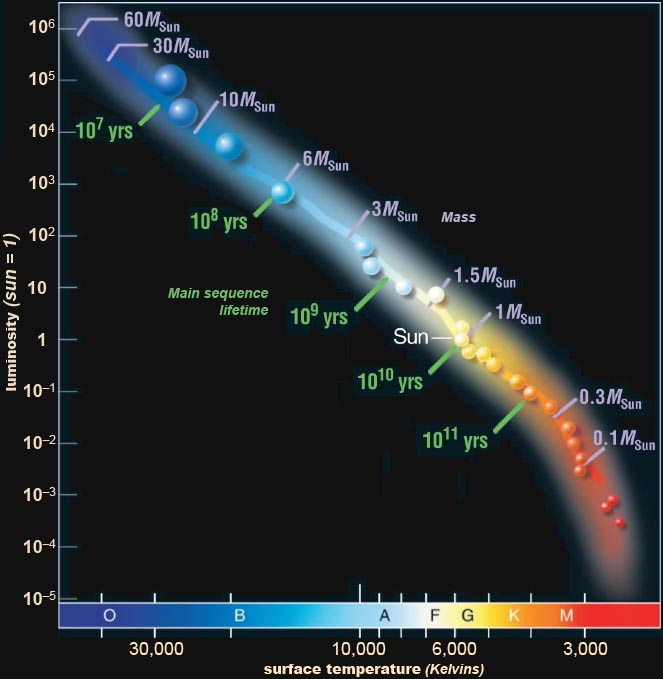

The main sequence is laid out on Hertzberg-Russel diagram above. Our M dwarfs are above the M part of the surface temperature axis, colored in red. You can see the approximate stellar masses and lifetime, with M dwarfs clocking in at at least 10^11 years, an order of magnitude larger than our own Sun.

# Are flares linked to spots?

The primary goal of this project is to tell whether or not the presence of spots on the surface of a star is linked to stellar activity in the form of flares. In this case the stars in question are too far in order to individually count spots or plages like we can with bright flares that pop out of the time curve. However we can use a rule of thumb to characterize the side of the star that faces us when we detect a flare. If the star is dimmer than normal than we can reasonably assume that the side facing us features many spot. If it's brighter we can safely say the star has loads of plages. Flares can be released in any direction at any given time, however if we actually detect them then it's much more likely that it was emitted on the face of the star facing us. This means that we can use the spot modulation flux at the time of detection of a flare to characterize whether or not the flare was released from a region with a lot of plages or spots.

So that's how we can characterize whether or not a flare was released from a region with spots of plages. Now where's the correlation? Well let's just plot a histogram of the spot modulation fluxes at the times of the flares. If the majority of them are at negative values then flares do indeed occur more often with spots. Previous work from Martin et al 2024 produces the following results from 163 flare measurements:

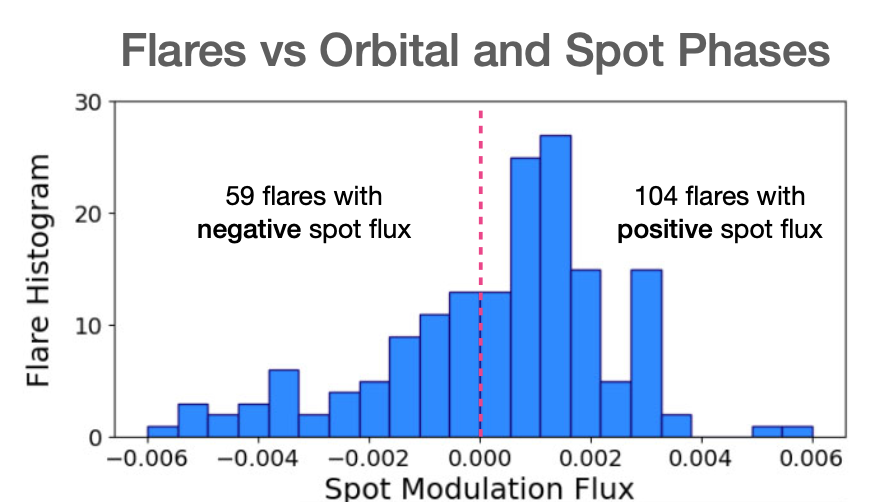

In our project, we will attempt to reproduce this plot, while also taking into account uncertainty and attempting to do some additional analysis on the flares and spots.

## Accounting for uncertainties

If there's one thing we should have already picked up from this class it's that there's no such thing as absolutely precise measurement. There's always an error or uncertainty we need to account for. No graph should be lacking in error bars because otherwise we cannot be sure whether or not the differences in two outcomes is statistically significant.

In our case we will have two populations, one that is eclipsing and one that is for the general population. We will then bin the data and plot their distribtion. The main source of uncertainty is in the number counts of items in each bin. For this we can use Poisson Error to model the error.

So imagine taking some histogram:

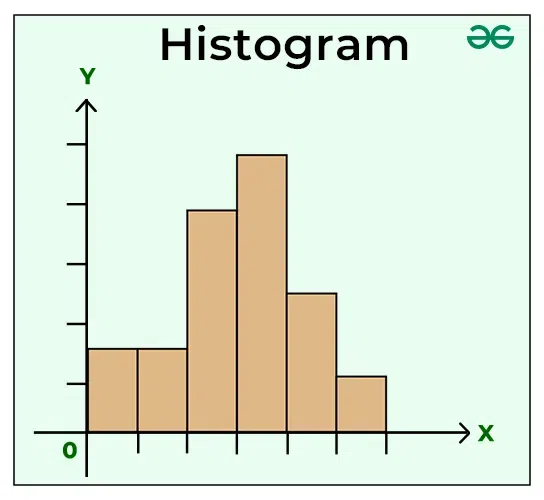

Now focus on one bin of that histogram, one of those bars. That bar is counting up the number of values that falls between two values. But that number is not constant, different trials may return different values for that single bin. The number of items in that bin will also follow a distribution. What are some things we can say about this distribution? In our case we can say for certain the events are independent. This means that just because some value of some particular parameter such as eccentricity won't affect the value of the next binary system. We can also say that for our populations, both the general population and the binary population, the rate at which some value such as eccentricity falls into some bin is independent of the number of objects in the population. Regardless of whether or not we're talking about a population of 100 binaries or 1,000,000 binaries, only a set fraction of them will fall into a certain bin.

With these two conditions adequately met we can model the distribution of number of items in each bin of the histogram as a Poisson distribution! For our purposes the success of a trial corresponds to an object belonging to our bin in question. So if we have a population of size n and the probability that any one of those objects falls into our bin is p then we get the factor λ as $\lambda = np$. But notice $\lambda = np \approx N$ where N is the number of items we counted in the bin! Since the variance of a Poisson distribtution is $\sigma^2 = \lambda$ the uncertainty can be expresses as $\sigma = \sqrt{N}$.

That may have felt like a long walk for a small drink of water but what we've done is pretty powerful. We've found we can use our histogram to estimate the uncertainty with a really easy form! So long as we make sure that the events are independent and the rate of success doesn't depend on the size of the sample this should work. In our system these are met as one flare shouldn't trigger another even if they're correlated to certain regions on a stars surface, so the events should be independent. We also can assume the size of our sample or shouldn't affect the rate at which we find a flare to have occurred at a certain spot modulated flux, it's an inherent quality of flares. This, of course, isn't a silver bullet. It's debated whether or not Poisson is overused in the field and whether or not binomial confidence interval (deriving from a more general binomial distribution) is more reliable. So always make sure to do your homework before choosing an error analysis, especially in the case of small number counts in each bin.

Below is a code to generate Poisson error for any normalized histogram. It's pretty straightforward, we'll generate a histogram of values using np.histogram() and take the square root of the resulting array, which should return an array of the uncertainty of each bin of the histogram. Then we need to normalize it by dividing the error by the integral of the histogram, equal to the sum of the values of the histogram times the bin width. I also want to add that I'm going to make the bins themselves a callable. This is because when we plot the histograms I want the bins of the general and eclipsing populations to have identicle bins to make the plot look pretty. I'll also return the bin centers to make plotting easier.

In [ ]:
flux_bins = np.linspace(-0.007, 0.007, 11)

def poisson_error(data, bins):
    #create the histogram of the array
    data_hist, bins = np.histogram(data, bins = bins)

    #find the poisson uncertainty
    poisson_error = abs(data_hist)**0.5

    #find the y values of the distribution so we can plot it
    data_hist_norm, bins = np.histogram(data, bins = bins)

    #find bin centers
    #while loop works best because the bin centers list won't be the same size
    bin_centers = []
    i = 0
    while i < len(bins) - 1:
        #calulate the average of two bin values and add it to the list
        bin_centers.append((bins[i] + bins[i+1])/2)
        i = i + 1
    return bin_centers, data_hist, abs(poisson_error)


def normalized_poisson_error(data, bins):
    #create the histogram of the array
    data_hist, bins = np.histogram(data, bins = bins)

    #find the poisson uncertainty
    poisson_error = abs(data_hist)**0.5

    #normalize it by dividing by the integral of the histogram
    poisson_error_normalized = poisson_error / (sum(data_hist) * (abs(bins[1] - bins[0])))

    #find the y values of the normalized distribution so we can plot it
    data_hist_norm, bins = np.histogram(data, bins = bins, density = True)

    #find bin centers
    #while loop works best because the bin centers list won't be the same size
    bin_centers = []
    i = 0
    while i < len(bins) - 1:
        #calulate the average of two bin values and add it to the list
        bin_centers.append((bins[i] + bins[i+1])/2)
        i = i + 1
    return bin_centers, data_hist_norm, abs(poisson_error_normalized)

## Spot Modulation Flux vs. Flare Occurrence

To begin our analysis into how the spot modulation flux is tied to flares, we must first calculate the specific spot modulation flux when those flares occurred! Since we have the time of each flare and the spot modulation flux at each time, we can just link the two across the flare time array.

In [ ]:
#find the index of the flare_time in the spots_time
flare_index = np.zeros(len(flare_time))
for ii in range(0, len(flare_time)):
    flare_index[ii] = np.argmin(np.abs(spots_time-flare_time[ii]))

#convert flare_index to integer
flare_index = flare_index.astype(int)
spot_flux_when_flare = spots_flux[flare_index]

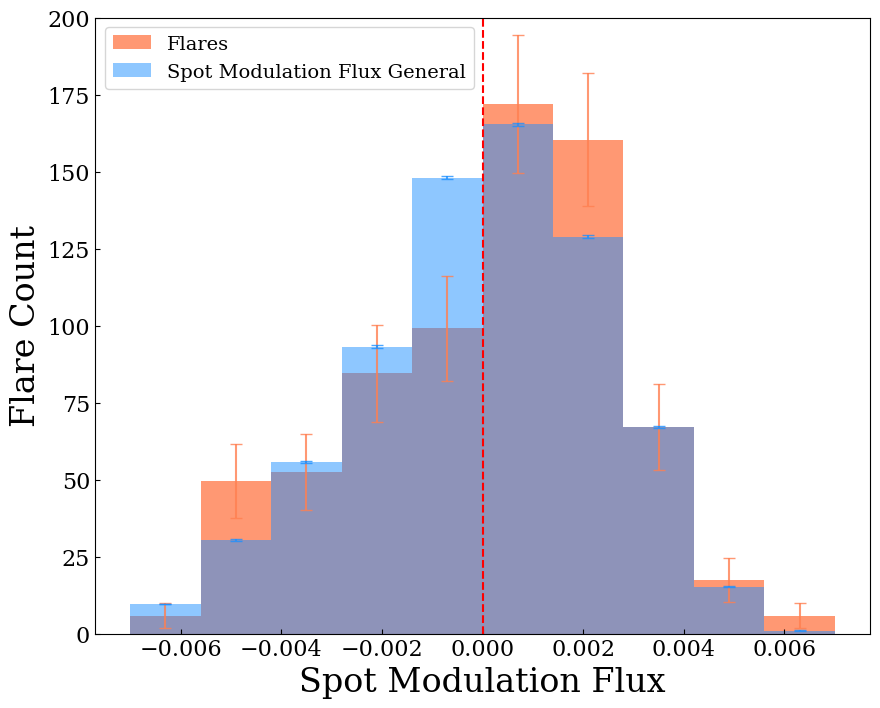

The number of flares across our dataset is  245
The mean normalized flux of the spot modulation at all times is  1.2324987151348666e-10
The mean normalized flux of the spot modulation when a flare occurs is 0.0001307864899401084
The standard deviation of the normalized flux of the spot modulation when a flare occurs is 0.0025090400586885706


In [ ]:
##Add error bars suing normalized poisson error
flux_bins = np.linspace(-0.007, 0.007, 11)

#for general sample -- calling the normalized_possion_error function we
#defined earlier to determine the errors on our histogram
general_flux_bin_centers, general_flux_norm, general_flux_sigma = normalized_poisson_error(spots_flux, flux_bins)
#for flares
flare_flux_bin_centers, flare_flux_norm, flare_flux_sigma = normalized_poisson_error(spot_flux_when_flare, flux_bins)

y_max = 200

# Plot the histogram of the spot modulation flux for flares and the general sample
plt.figure(figsize = (10,8))
# for flares
plt.hist(spot_flux_when_flare, bins = flux_bins, color = 'coral', label = 'Flares', density = True, alpha = 0.8) #
plt.errorbar(flare_flux_bin_centers, flare_flux_norm, yerr = flare_flux_sigma, capsize = 4, color = 'coral', linestyle = '', alpha = 0.8)
# for general sample
plt.hist(spots_flux, bins = flux_bins, color = 'dodgerblue', label = 'Spot Modulation Flux General', density = True, alpha = 0.5)
plt.errorbar(general_flux_bin_centers, general_flux_norm, yerr = general_flux_sigma, capsize = 4, color = 'dodgerblue', linestyle = '', alpha = 0.8)

# plot formatting
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('Spot Modulation Flux', fontsize = 24)
plt.ylabel('Flare Count', fontsize = 24)
plt.tick_params(direction = 'in', labelsize = 16)
plt.ylim(0, y_max)
plt.legend(fontsize = 14, loc = 'upper left')
plt.show()

# print statistics
print('The number of flares across our dataset is ', len(flare_index))
print('The mean normalized flux of the spot modulation at all times is ', np.mean(spots_flux))
print('The mean normalized flux of the spot modulation when a flare occurs is', np.mean(spot_flux_when_flare))
print('The standard deviation of the normalized flux of the spot modulation when a flare occurs is', np.std(spot_flux_when_flare))

In [ ]:
# Calculate the percentage of flares with a negative or positive spot modulation flux
flare_count_negative_spot_flux = 0
flare_count_positive_spot_flux = 0
for flux in spot_flux_when_flare:
  if flux <0:
    flare_count_negative_spot_flux += 1
  if flux > 0:
    flare_count_positive_spot_flux += 1

# print the percentage of flares with a negative or positive spot modulation flux
print('Percentage of flares with a negative spot modulation flux = ' + str(flare_count_negative_spot_flux/len(spot_flux_when_flare)*100))
print('Percentage of flares with a positive spot modulation flux = ' + str(flare_count_positive_spot_flux/len(spot_flux_when_flare)*100))

Percentage of flares with a negative spot modulation flux = 40.816326530612244
Percentage of flares with a positive spot modulation flux = 59.183673469387756


What does this mean?

Well, it seems that there are a greater number of flares when the spot modulation flux is positive, or when there are more plages present on the two stars's surface. Or, to put it another way, the positive spot modulation flux indicates that the spots on the stars are making them brighter than average. Starspots and plages both indicate regions of intense magnetic activity, and it is that intense magnetic activity that leads to solar flare. However, one would usually expect more flares when the spot modulation flux is negative, as more spots are facing us on Earth. The opposite is true in this case!

When looking at the overall stellar activity, aka the spot modulation flux, we see a relatively normal ditribution of fluxes, showing the stellar activity fluctuates relatively evenly between spots and plages and is centered and most commonly at 0. 0 spot modulation flux indicates that there is no particular increase in magnetic activity on the stars. Meanwhile, the spot modulation flux when a flare occures is skewed positive, indicating a correlation between the increased magnetic activity on the stellar surface, that we can detect in the light curve, and increased flare occurrence.

### Student t-test

We have talked about the Z-test and t-test in class a bit so here is a reminder about what the t-test is. The main reason we don't use a Z-test here is because we don't know the population standard deviation $\sigma$, which is required to take a Z-test. We can instead use the sample standard deviation $s$.

In our case we are only going to comparing one distribution against a null hypothesis so the relevant t statistic is calculated as

$$ t = \frac{\bar{x}-\mu}{s/\sqrt{n}} $$

Since we are comparing with a null hypothesis, we also need a relevant p-value so that we cant test how our likely our sample distribution (or a weirder one) is given that that the null hypothesis is true.

For a Z-test the p-values is somewhat straightforward to find since the Z statistic follows a normal distribution, but for a t-test it is a bit more complicated since the t statistic follows a separate t-distribution:

$$ f(x) = \frac{\Gamma[(\nu+1)/2]}{\Gamma(\nu/2)} \frac{1}{\sqrt{\nu n}}\frac{1}{(1+x^2/\nu)^{\nu+1)/2}}$$

$\nu$ is the "degrees of freedom" and $\Gamma$ is the "Gamma function":

$$ \Gamma(\alpha) = \int_0^{\infty}x^{\alpha-1}e^{-x}dx $$

So we can just use scipy t-test to determine the p-value to avoid finding it based on the above function from scratch.

In [ ]:
#find the mean of the population, the total list of fluxes for the stars
spot_flux_avg = 0 # this is given by the fact that we define the average flux to be zero

def t_test(rand_fluxes):
    #find the average flux of the sample (the fluxes at the times of the flares)
    rand_flux_avg = np.mean(rand_fluxes)
    #find the standard deviation of the sample
    rand_flux_s = np.std(rand_fluxes)
    #find the standard error using the std of the sample and the size of the sample
    stand_err = rand_flux_s / len(rand_fluxes)**0.5
    #calculate t value
    t_value = (rand_flux_avg - spot_flux_avg)/stand_err

    return t_value

print('The Student t-test value of the spot modulation flux in the event of a flare is ' + str(t_test(spot_flux_when_flare)))

#generate the t_test cdf for the number of degrees of freedom
#for our sample, equal to the number of data points
#of the spot modulaton flux minus one

#degrees of freedom
df = len(spot_flux_when_flare) - 1 #should be like 223
t_test_cdf = student_t.cdf(np.linspace(-5, 5, 100), df)

#now find the p-value from the t-test cdf
#find the prob of events with small t_test values
p_value_low = student_t.cdf(-abs(t_test(spot_flux_when_flare)), df)
#find the prob of events with large t_test values
p_value_high = 1 - student_t.cdf(abs(t_test(spot_flux_when_flare)), df)

#add them up to get probability that null hypothesis can replicate the results seen
p_value_from_t_test = p_value_low + p_value_high

#print result
print('')
print('The probability that the general spot modulation flux distribution can produce the distribution seen \n' +
      'when there is a flare or rarer is ' + str(round(p_value_from_t_test, 3)))

The Student t-test value of the spot modulation flux in the event of a flare is 0.8159026266733749

The probability that the general spot modulation flux distribution can produce the distribution seen 
when there is a flare or rarer is 0.415


### Bootstrapping

We can implement bootstrapping to see whether or not this result is truly strange or whether we got lucky with such a positive result. To do this we'll bootstrap p-values.

We can start, though, by bootstrapping a large amount of random samples and plotting the statistics on that to see what kind of distribution unfolds.

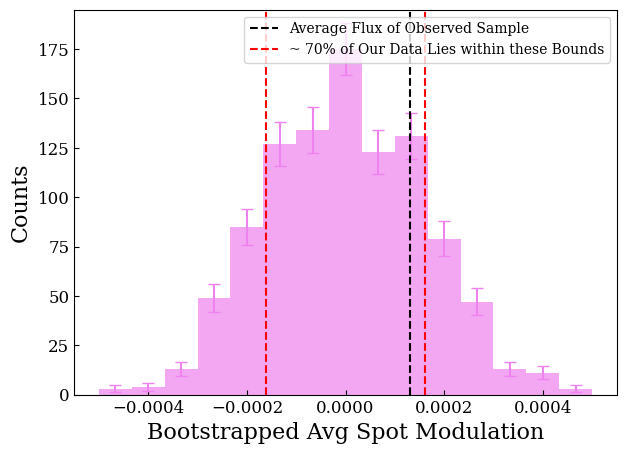

In [ ]:
#Define a function that will build the bootstrapped set from a null distribution
#meaning the average will be centered around zero
#and find their average flux values to compare with out measured data
#to see how exceptional our data is

#n defines size of each sample
#N defines number of samples

def bootstrap_null_means(data, n, N):
    #initialize a list of the means of each bootstrapped sample
    bootstrap_means = []

    #find the sample mean so we can create a distribution for the null hypothesis
    sample_mean = np.mean(data)

    #create a distribution representing the null hypothesis by adding the difference
    #between the population average (0) and the sample mean
    null_data = data - sample_mean
    i = 0
    #continue running until we get N averages
    while i < N:
        #generate random spot modulation fluxes from the list
        random_fluxes = np.random.choice(null_data, n, replace = True)
        #find the mean of this sample
        bootstrap_means.append(np.mean(random_fluxes))
        i = i + 1
    return bootstrap_means

# perform the bootstrapping
n = len(spot_flux_when_flare)
N = 1000
bootstrapped_avg_flare_fluxes = bootstrap_null_means(spot_flux_when_flare, n, N)
bootstrapped_std = np.std(bootstrapped_avg_flare_fluxes)
bootstrapped_peak = np.mean(bootstrapped_avg_flare_fluxes)
observed_flux_average = np.mean(spot_flux_when_flare)
bootstrap_bins = np.linspace(-5e-4, 5e-4, 16)

#find the uncertainty
#this will have be done manually because it's not normalized
bootstrap_flux_bin_centers, bootstrap_flux, bootstrap_flux_sigma = poisson_error(bootstrapped_avg_flare_fluxes, bootstrap_bins)


#plot the histogram of the bootstrapped average spot modulation fluxes
#and the observed average spot modulation flux
y_max = 195

plt.figure(figsize = (7, 5))
plt.hist(bootstrapped_avg_flare_fluxes, bins = bootstrap_bins, color = 'violet', alpha = 0.7)

plt.errorbar(bootstrap_flux_bin_centers, bootstrap_flux, yerr = bootstrap_flux_sigma,
            linestyle = '', capsize = 4, color = 'violet', alpha = 1.0)
plt.vlines(observed_flux_average, 0, y_max, linestyle = '--', color = 'black', label = 'Average Flux of Observed Sample')
plt.vlines(bootstrapped_peak - bootstrapped_std, 0, y_max, linestyle = '--', color = 'red', label = '~ 70% of Our Data Lies within these Bounds')
plt.vlines(bootstrapped_peak + bootstrapped_std, 0, y_max, linestyle = '--', color = 'red')
plt.xlabel('Bootstrapped Avg Spot Modulation', fontsize = 16)
plt.ylabel('Counts', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 12)
plt.ylim(0, y_max)
plt.legend(fontsize = 10)
plt.show()

In [ ]:
#Calculate the p value, equal to the percentage of bootstrapped means that are
#as strange or rarer than our measured average

#find the percentage of low value items
p_low_values = len(np.where((bootstrapped_avg_flare_fluxes < -1 * observed_flux_average))[0]) / len(bootstrapped_avg_flare_fluxes)
#find the percentage of high value items
p_high_values = len(np.where((bootstrapped_avg_flare_fluxes > observed_flux_average))[0]) / len(bootstrapped_avg_flare_fluxes)
#add them together to get p value
p_value = p_low_values + p_high_values

print('The p-value of the observed average compared to the null distribution via bootstrapping is ' + str(round(p_value, 3)))

The p-value of the observed average compared to the null distribution via bootstrapping is 0.427


Because the p-values will be susceptible to statistical varianc, it may be best to calculate loads of them and characterize them, as opposed to comparing our real data to the bootstrapped distribution one time.

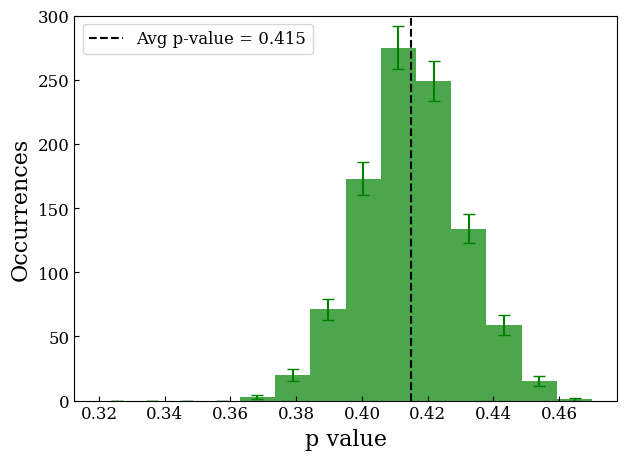

In [ ]:
# Create a histogram for p-values of many iterations of bootstrapped p-values
#data is observed data, in this case the fluxes at the times of the flares
#N is the number of bootstrapped samples we use each time we calculate the p value
#reps is number of p values we wish to generate

def bootstrap_p_value(data, N, reps):
    #define the average flux value for the population of flares
    #the we observed in the data
    observed_flare_flux_avg = np.mean(spot_flux_when_flare)

    #initialize a list to hold p values
    p_values = np.zeros(reps)
    for i in range(reps):
        #Create a list of bootstrapped means of the null population
        #we want each bootstrapped sample to have as many objects as the observed sample
        #otherwise the p values won't be representative of our data
        n = len(data)
        bootstrapped_avgs = bootstrap_null_means(data, n, N)

        #calculate the p value from this trial, equal to the percentage of bootstrapped
        #averages as far or farther from the null population mean (equal to zero) as the data is
        #find the indices of all the items with exceptionally low averages
        low_indices = np.where((bootstrapped_avgs < - np.abs(observed_flare_flux_avg)))[0]

        #find the percentage of items with low averages as the number of items with exceptionally low averages
        #divided by the total number of bootstrapped samples, N
        p_value_low = len(low_indices) / N

        #find the indices of all the items with exceptionally high averages
        high_indices = np.where((bootstrapped_avgs > np.abs(observed_flare_flux_avg)))[0]

        #find the percentage of items with low averages as the number of items with exceptionally low averages
        #divided by the total number of bootstrapped samples, N
        p_value_high = len(high_indices) / N

        #add together to get p_value
        p_value = p_value_low + p_value_high

        #append to list
        p_values[i] = (p_value)
    return p_values

#plot their distribution as a histogram
N = 1000
reps = 1000
p_value_dist = bootstrap_p_value(spot_flux_when_flare, N, reps)
p_value_peak = np.mean(p_value_dist)
y_max = 300
p_value_bins = np.linspace(0.32, 0.47, 15)

#find the error
p_value_bin_centers, p_values, p_vlaue_sigma = poisson_error(p_value_dist, p_value_bins)

plt.figure(figsize = (7, 5))
plt.hist(p_value_dist, bins = p_value_bins, color = 'green', alpha = 0.7)
plt.errorbar(p_value_bin_centers, p_values, yerr = p_vlaue_sigma,
             linestyle = '', capsize = 4, color = 'green', alpha = 1.0)
plt.vlines(p_value_peak, 0, y_max, linestyle = '--', color = 'black',
           label = ('Avg p-value = ' + str(round(p_value_peak,3))))
plt.xlabel('p value', fontsize = 16)
plt.ylabel('Occurrences', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 12)
plt.ylim(0, y_max)
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

From boostrapping these p-values and find the distribution of them, we can see that our p-value falls very clearly around 0.41 or so. Assuming the default p$<$0.05 as a test of the validity of the null hypothesis, we can confidently say that the null hypothesis holds in this case. Or, to put it another way, our results do not represent an extreme outlier of this sample!

## Spot Modulation Flux vs. Flare Amplitude and Energy

Now that we've investigate the spot modulation flux as to how it relates to the occurrence of a falre, we can see if the spot modulation flux correlates to stronger or weaker flares. Since, as discussed earlier, stellar spots indicate regions of higher magnetic activity, we would assume that there was some relationship between greater flux from spots and greater flare amplitude or energy.

To start our analysis, let's just spot the spot modulation flux during a flare and the amplitude of that flare, as well as the the spot modulation flux during a flare and the energy of that flare.

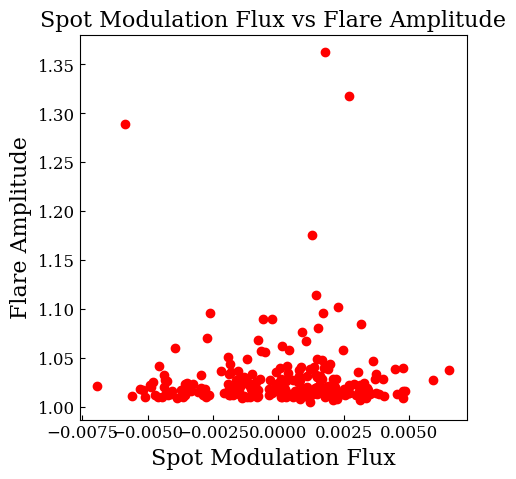

In [ ]:
# plot spot modulation flux vs. flare amplitude
plt.figure(figsize = (5, 5))
plt.scatter(spot_flux_when_flare, flare_amp, color = 'red')
plt.title('Spot Modulation Flux vs Flare Amplitude', fontsize = 16)
plt.xlabel('Spot Modulation Flux', fontsize = 16)
plt.ylabel('Flare Amplitude', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 12)
#plt.xscale('log')

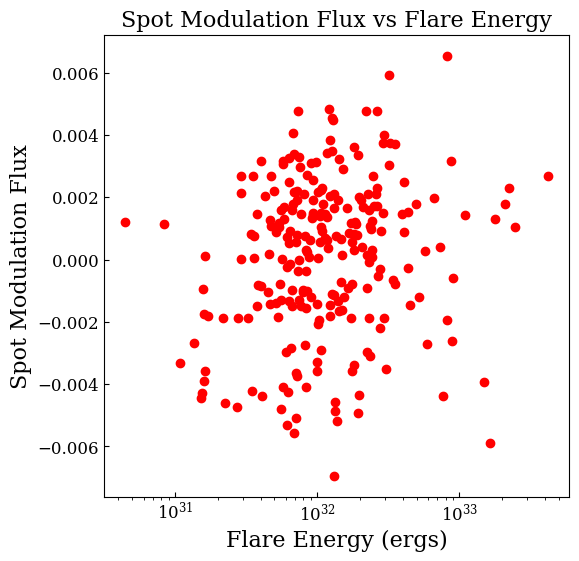

In [ ]:
# plot log of flare energy vs spot modulation flux
plt.figure(figsize = (6, 6))
plt.scatter(flare_energy, spot_flux_when_flare, color = 'red')
plt.title('Spot Modulation Flux vs Flare Energy', fontsize = 16)
plt.xlabel('Flare Energy (ergs)', fontsize = 16)
plt.ylabel('Spot Modulation Flux', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 12)
plt.xscale('log')

To naked eye, it doesn't appear like these datasets are strongly related to each other. Let's analyze this more quantitaively though, which we can do by using our bootstrapping method from earlier and calculating pearson coefficients for each bootstrapped sample.

### Bootstrapping a Pearson Coefficient

Using the above distribution of spot modulation flux vs flare energy, we can boostrap these points and an associated Pearson Coefficient $r$ which measures the linear correlation between these two quantities. Pearson Coefficients quantitatively measure how correlated 2 populations are with each other.

For the case of a dataset $(x,y)$ with $n$ datapoints and $i$ representing a specific datapoint, then:

$$ r = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i-\bar{y})}{\sqrt{\sum_{i=1}{n}(x_i - \bar{x})^2\sum_{i=1}^{n}(y_i - \bar{y})^2}} $$

where $\bar{x}$ is the mean of $x$ and $\bar{y}$ is the mean of $y$. If there is no correlation between $x$ and $y$ then $r=0$. If there is a positive correlation then $r=1$. Negative correlation: $r=-1$.

So by boostrapping this quantity along with our data, we can test with confidence if a correlation in the data exists.

In [ ]:
# calculates the r values of various random samples from the x and y datasets
def pearson_bootstrap(x, y, n, N):
    r_values = []
    i = 0
    while i < N: #create random sample
        indices = np.random.randint(0, len(x), n)
        x_rand = x[indices]
        y_rand = y[indices]
        x_mean = np.mean(x_rand)
        y_mean = np.mean(y_rand)
        r = np.sum((x_rand - x_mean)* (y_rand - y_mean)) / np.sqrt(np.sum((x_rand - x_mean)**2) * np.sum((y_rand - y_mean)**2))
        r_values.append(r)
        i = i + 1
    return r_values


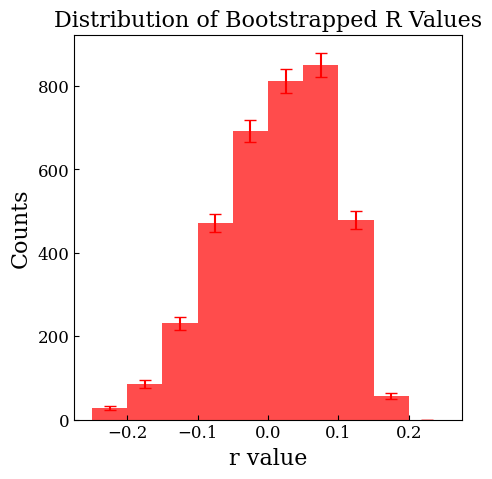

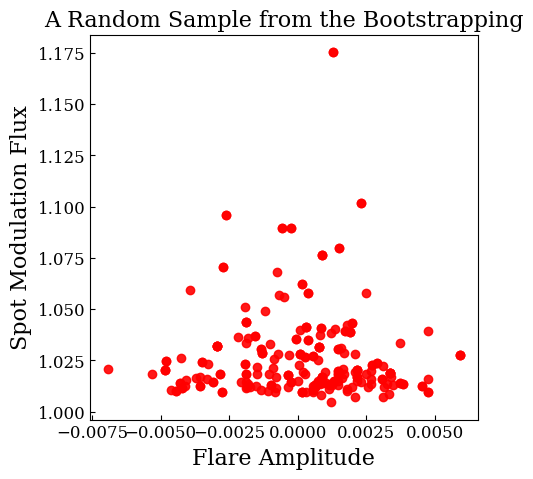

In [ ]:
n = len(spot_flux_when_flare)
N = 10000

r_values = pearson_bootstrap(flare_amp, spot_flux_when_flare, n, N)
r_value_bins = np.linspace(-0.25, 0.25, 11)
r_value_bin_centers, r_value_points, r_value_sigma = poisson_error(r_values, r_value_bins)

plt.figure(figsize = (5, 5))
plt.hist(r_values, bins = r_value_bins, color = 'red', alpha = 0.7)
plt.errorbar(r_value_bin_centers, r_value_points, yerr = r_value_sigma, linestyle = '', capsize = 4, color = 'red', alpha = 1.0)
plt.title('Distribution of Bootstrapped R Values', fontsize = 16)
plt.xlabel('r value', fontsize = 16)
plt.ylabel('Counts', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 12)
plt.show()

# plot a random sample to see what it looks like, as a sanity check
indices = np.random.randint(0, len(flare_amp), n)
flare_amp_rand = flare_amp[indices]
flare_flux_rand = spot_flux_when_flare[indices]
plt.figure(figsize = (5, 5))
plt.scatter(flare_flux_rand, flare_amp_rand, color = 'red', alpha = 0.9)
plt.title('A Random Sample from the Bootstrapping', fontsize = 16)
plt.xlabel('Flare Amplitude', fontsize = 16)
plt.ylabel('Spot Modulation Flux', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 12)
plt.show()

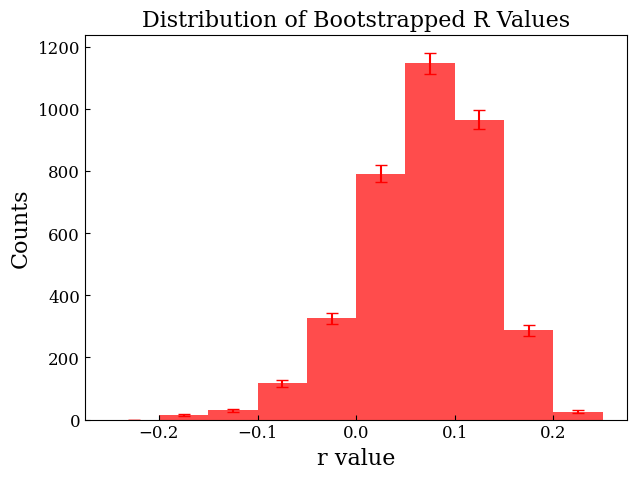

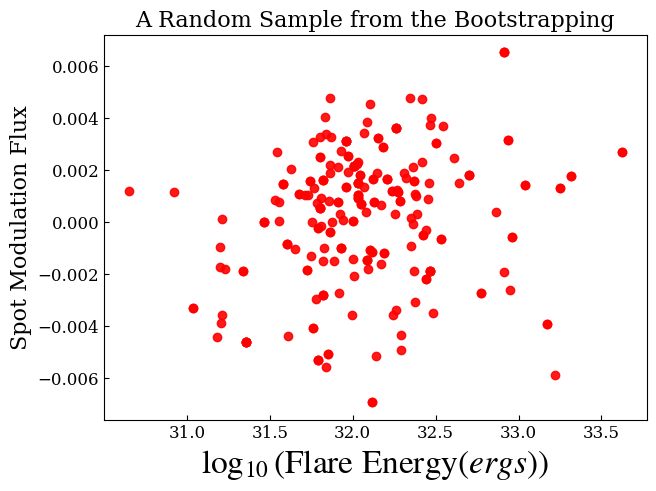

In [ ]:
n = len(spot_flux_when_flare)
N = 10000

r_values = pearson_bootstrap(flare_energy, spot_flux_when_flare, n, N)
r_value_bins = np.linspace(-0.25, 0.25, 11)
r_value_bin_centers, r_value_points, r_value_sigma = poisson_error(r_values, r_value_bins)

plt.figure(figsize = (7, 5))
plt.hist(r_values, bins = r_value_bins, color = 'red', alpha = 0.7)
plt.errorbar(r_value_bin_centers, r_value_points, yerr = r_value_sigma, linestyle = '', capsize = 4, color = 'red', alpha = 1.0)
plt.title('Distribution of Bootstrapped R Values', fontsize = 16)
plt.xlabel('r value', fontsize = 16)
plt.ylabel('Counts', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 12)
plt.show()

# plot a random sample to see what it looks like, as a sanity check
indices = np.random.randint(0, len(flare_energy), n)
flare_intensity_rand = flare_energy[indices]
flare_flux_rand = spot_flux_when_flare[indices]
plt.figure(figsize = (7, 5))
plt.scatter(np.log10(flare_intensity_rand), flare_flux_rand, color = 'red', alpha = 0.9)
plt.title('A Random Sample from the Bootstrapping', fontsize = 16)
plt.xlabel(r'$\log_{10}(\text{Flare Energy} (ergs))$', fontsize = 24)
plt.ylabel('Spot Modulation Flux', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 12)
plt.show()

## Orbital Phase vs. Flare Occurence

Now we can investigate if there is any correlation between the orbital position of the binary stars and the flare activity coming from the system! The point in the orbital phase also indicates when there is a primary or secondary eclipse. By checking those points in particular, we can investigate the indivudal stellar activity of each star in CM Draconis!

In order to do this analysis, first we must analyze the light curve and assign phases to each time step. To do this, we can identify when either a primary or secondary eclipse occurs and step forward through the times in the lc_time array.

In [ ]:
# Define estimate of the period
period = 1.3

# Define the range to search for the minimum flux around each jump
search_range = 0.1

# Find the index of the known primary eclipse
start_index = np.searchsorted(lc_time, 1948 - search_range)
end_index = np.searchsorted(lc_time, 1948 + search_range)
min_flux_index = start_index + np.argmin(lc_flux[start_index:end_index])

known_eclipse_index = min_flux_index

# Initialize the list of primary eclipse indices
primary_eclipse_indices = [known_eclipse_index]

# Jump backwards in time
current_time = lc_time[known_eclipse_index]
while current_time > lc_time[0]:
    current_time -= period

    if current_time < lc_time[0]:
        break
    start_index = np.searchsorted(lc_time, current_time - search_range) # find the index of the time that is 0.1 days before the current time
    end_index = np.searchsorted(lc_time, current_time + search_range) # find the index of the time that is 0.1 days after the current time
    if(start_index != end_index):
        min_flux_index = start_index + np.argmin(lc_flux[start_index:end_index]) # find the index of the minimum flux in the range
        primary_eclipse_indices.append(min_flux_index)

# Jump forwards in time
current_time = lc_time[known_eclipse_index]
while current_time < lc_time[-1]:
    current_time += period
    if current_time > lc_time[-1]:
        break
    start_index = np.searchsorted(lc_time, current_time - search_range) # find the index of the time that is 0.1 days before the current time
    end_index = np.searchsorted(lc_time, current_time + search_range) # find the index of the time that is 0.1 days after the current time
    if(start_index != end_index):
        min_flux_index = start_index + np.argmin(lc_flux[start_index:end_index]) # find the index of the minimum flux in the range
        primary_eclipse_indices.append(min_flux_index)

# Sort the indices
primary_eclipse_indices.sort()

# Print the primary eclipse indices and the number of primary eclipses
print(len(primary_eclipse_indices))
print(primary_eclipse_indices)

415
[np.int64(909), np.int64(1813), np.int64(2723), np.int64(3643), np.int64(4571), np.int64(5603), np.int64(6445), np.int64(7281), np.int64(8202), np.int64(9113), np.int64(10059), np.int64(10974), np.int64(11928), np.int64(12846), np.int64(13800), np.int64(14722), np.int64(15256), np.int64(16102), np.int64(17008), np.int64(17922), np.int64(18817), np.int64(19765), np.int64(20771), np.int64(21635), np.int64(22565), np.int64(23363), np.int64(24292), np.int64(25222), np.int64(26049), np.int64(26965), np.int64(27878), np.int64(28872), np.int64(29875), np.int64(30773), np.int64(31657), np.int64(32570), np.int64(33540), np.int64(34445), np.int64(35372), np.int64(36374), np.int64(37307), np.int64(38236), np.int64(39188), np.int64(39946), np.int64(40929), np.int64(41833), np.int64(42746), np.int64(43651), np.int64(44561), np.int64(45470), np.int64(46379), np.int64(47292), np.int64(48507), np.int64(49487), np.int64(50477), np.int64(51059), np.int64(51659), np.int64(52497), np.int64(53569), np.

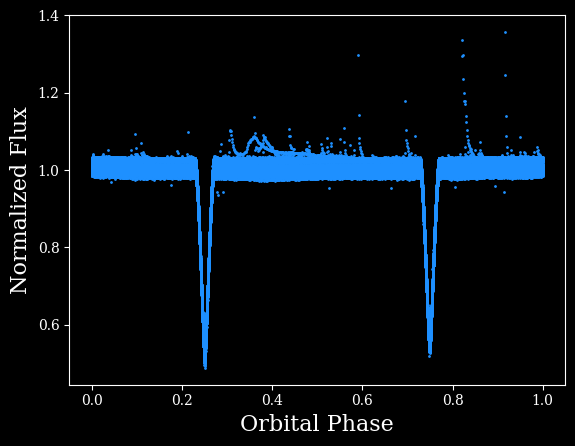

In [ ]:
# Extract the times of the primary eclipses
primary_eclipse_times = lc_time[primary_eclipse_indices]

high_accuracy_period = 1.268389985 #taken from Martin et. al. 2024

# Calculate the phase of each point in lc_time
first_primary_eclipse_time = primary_eclipse_times[0]
lc_phase = ((lc_time - first_primary_eclipse_time) % high_accuracy_period) / high_accuracy_period
lc_phase = lc_phase + 0.25 # shift the phase so that the primary eclipse is at phase 0.25
lc_phase = lc_phase % 1 # wrap the phase between 0 and 1

# plot the light curve phased to the high accuracy period

plt.style.use('dark_background')

fig = plt.figure()
plt.scatter(lc_phase, lc_flux, s=1, color='dodgerblue')
plt.xlabel('Orbital Phase', fontsize = 16)
plt.ylabel('Normalized Flux', fontsize = 16)
plt.show()

As seen in the plot above, we have assigned our orbital phases such that the phase is .25 when there is a primary eclipse, or a greater drop in the light curve, and that the phaes is .75 when there is a secondary eclipse. The phases accurately and consistently match up with the primary and secondary eclipses! So, we mapped this on correctly, yay.

With all this information, we can know recreate the other plot of figure 8 from Martin et. al. 2024, which displays the amount of flares in each orbital phase bin! We have two columns to highlight the bins that encapsulate the primary and secondary eclipses, as well as a line to indicate the average number of flares per bin. Assuming that the flare rate is independent of the orbit phase of the graph, we should see a uniform distribution along that horizontal line.

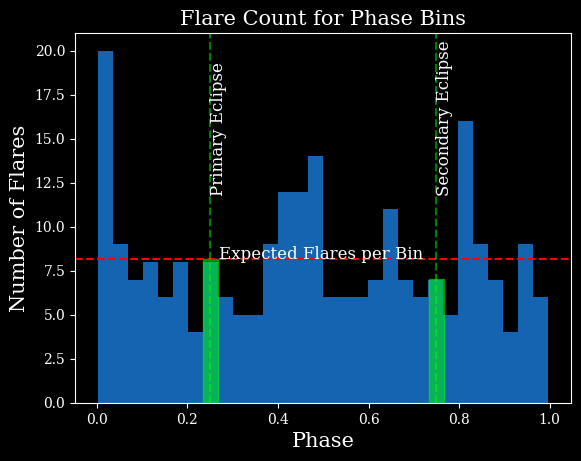

In [ ]:
# Define the number of bins

# 10 bins is centered on eclipses, 30 is too, idk pick one
num_bins = 30

# Plot histogram of flare count for phase bins
plt.style.use('dark_background')
fig = plt.figure()
plt.hist(lc_phase[flare_index], bins=num_bins, color= 'dodgerblue', alpha=0.7)
plt.axhline(y=len(flare_index)/num_bins, color='red', linestyle='--')
plt.axvspan(0.25-1/num_bins/2, .25+1/num_bins/2, ymin = 0, ymax = .39, color='lime', alpha = .5)
plt.axvspan(0.75-1/num_bins/2, .75+1/num_bins/2, ymin = 0, ymax = .335, color='lime', alpha = .5)
plt.axvline(0.25, color='lime', ls = '--', alpha = .5)
plt.axvline(0.75,  color='lime', ls = '--', alpha = .5)
# Add labels for horizontal line
plt.text(0.27, len(flare_index)/num_bins, 'Expected Flares per Bin', rotation=0, fontsize = 12)
# Add labels for vertical lines
plt.text(0.25, 12, 'Primary Eclipse', rotation=90, fontsize = 12)
plt.text(0.75, 12, 'Secondary Eclipse', rotation=90, fontsize = 12)
plt.title('Flare Count for Phase Bins', fontsize = 15)
plt.xlabel('Phase', fontsize = 15)
plt.ylabel('Number of Flares', fontsize = 15)
plt.show()

Interesting! It seems that orbital phase does have some impact on the amount of flares we see, but not in the way we might expect. One might assume that during a primary or secondary eclipse, since one of the two stars is covered up, we would see fewer flares as there would be less overall visible stellar activity. Instead, while we do see a relatively high number of eclipses when the two stars are not blocking each other (at a phase of .5 or 0), the primary or secondary eclipses do not have substantilally fewer flares than we would expect. While our data and analysis disgree with Martin et. al. 2024's claim that there are MORE flares during eclipses, we don't see a substantial decrease either.

## Orbital Phase vs. Flare Amplitude and Energy

Now we can investigate whether there is any correlation between phase and flare amplitude and energy! Similar to what we did with spot modulation flux and flare amplitude/energy, we can plot our samples and, via bootstrapping, see how correlated they are based on their respective r values.

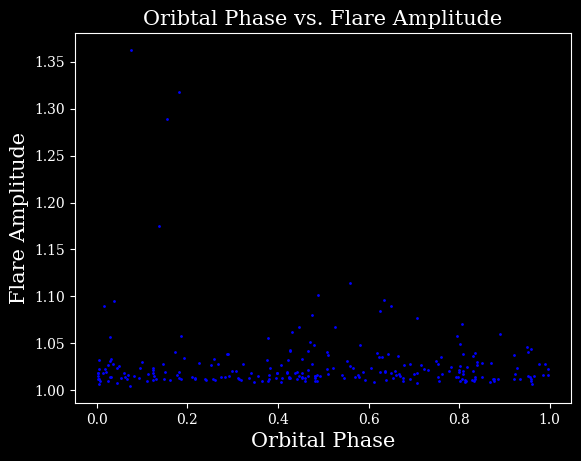

In [ ]:
# plot the orbital phase of CM Draconis at the time of each flare
# vs. that flare's amplitude
fig = plt.figure()
plt.scatter(lc_phase[flare_index], flare_amp, s=1, color='blue')
plt.title('Oribtal Phase vs. Flare Amplitude', fontsize = 15)
plt.xlabel('Orbital Phase', fontsize = 15)
plt.ylabel('Flare Amplitude', fontsize = 15)
plt.show()

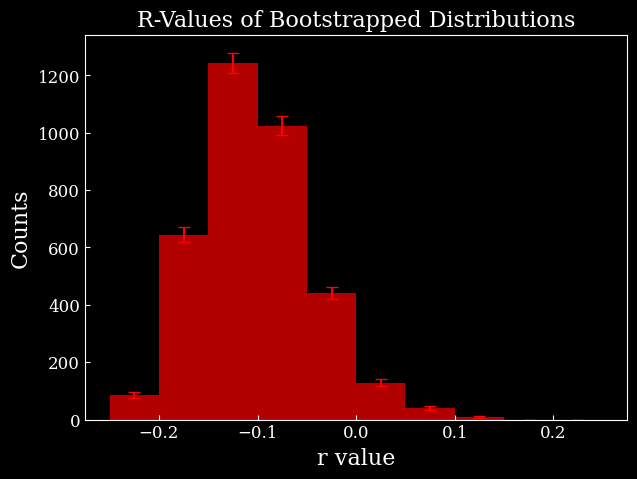

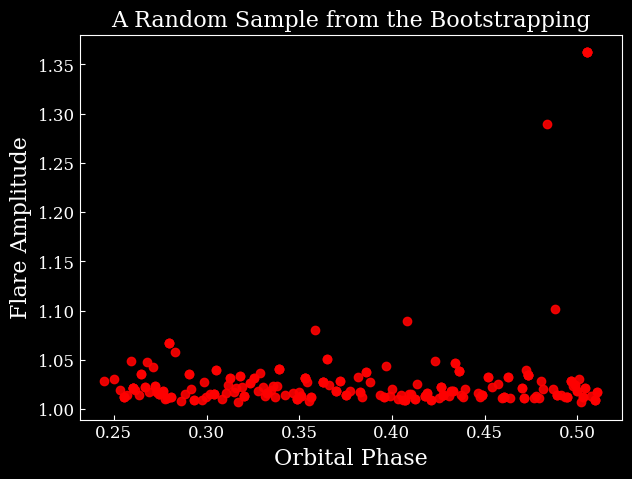

In [ ]:
n = len(flare_amp)
N = 10000

r_values = pearson_bootstrap(lc_phase[flare_index], flare_amp, n, N)
r_value_bins = np.linspace(-0.25, 0.25, 11)
r_value_bin_centers, r_value_points, r_value_sigma = poisson_error(r_values, r_value_bins)

plt.figure(figsize = (7, 5))
plt.hist(r_values, bins = r_value_bins, color = 'red', alpha = 0.7)
plt.errorbar(r_value_bin_centers, r_value_points, yerr = r_value_sigma, linestyle = '', capsize = 4, color = 'red', alpha = 1.0)
plt.title('R-Values of Bootstrapped Distributions', fontsize = 16)
plt.xlabel('r value', fontsize = 16)
plt.ylabel('Counts', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 12)
plt.show()

#plot a random sample to see what it looks like
indices = np.random.randint(0, len(flare_amp), n)
flare_amp_rand = flare_amp[indices]
lc_phase_rand = lc_phase[indices]
plt.figure(figsize = (7, 5))
plt.scatter(lc_phase_rand, flare_amp_rand, color = 'red', alpha = 0.9)
plt.title('A Random Sample from the Bootstrapping', fontsize = 16)
plt.xlabel('Orbital Phase', fontsize = 16)
plt.ylabel('Flare Amplitude', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 12)
plt.show()

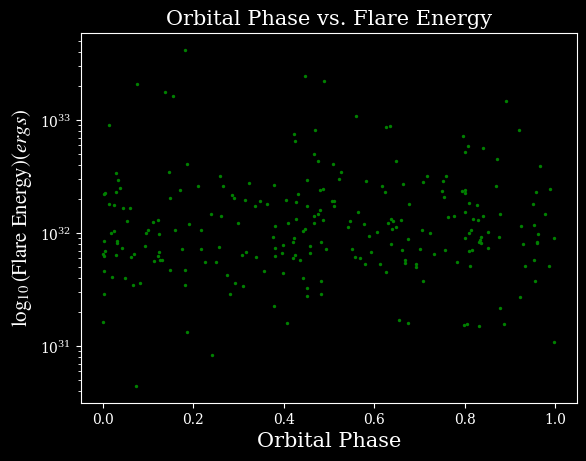

In [ ]:
# plot the orbital phase of CM Draconis at the time of each flare
# vs. that flare's energy
fig = plt.figure()
plt.scatter(lc_phase[flare_index], flare_energy, s=2, color='green')
plt.yscale('log')
plt.xlabel('Orbital Phase', fontsize = 15)
plt.title('Orbital Phase vs. Flare Energy', fontsize = 15)
plt.ylabel(r'$\log_{10}(\text{Flare Energy}) (ergs)$', fontsize = 15)
plt.show()

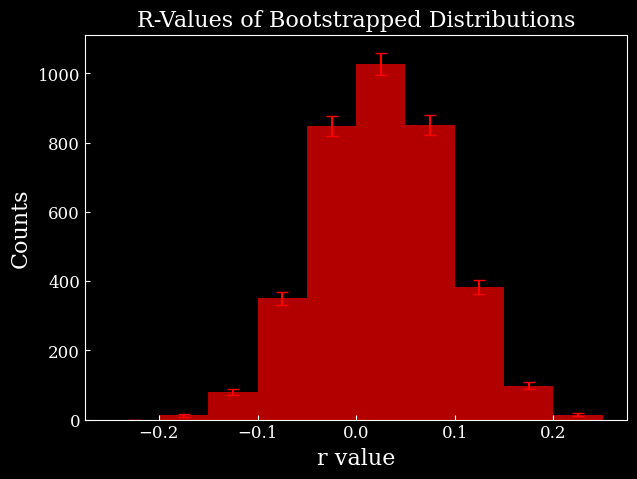

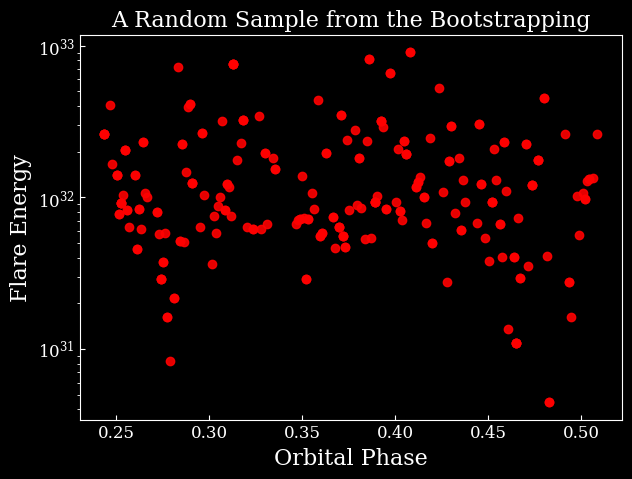

In [ ]:
n = len(flare_energy)
N = 10000

r_values = pearson_bootstrap(lc_phase[flare_index], np.log10(flare_energy), n, N)
r_value_bins = np.linspace(-0.25, 0.25, 11)
r_value_bin_centers, r_value_points, r_value_sigma = poisson_error(r_values, r_value_bins)

plt.figure(figsize = (7, 5))
plt.hist(r_values, bins = r_value_bins, color = 'red', alpha = 0.7)
plt.errorbar(r_value_bin_centers, r_value_points, yerr = r_value_sigma, linestyle = '', capsize = 4, color = 'red', alpha = 1.0)
plt.title('R-Values of Bootstrapped Distributions', fontsize = 16)
plt.xlabel('r value', fontsize = 16)
plt.ylabel('Counts', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 12)
plt.show()

#plot a random sample to see what it looks like
indices = np.random.randint(0, len(flare_energy), n)
flare_energy_rand = flare_energy[indices]
lc_phase_rand = lc_phase[indices]
plt.figure(figsize = (7, 5))
plt.scatter(lc_phase_rand, flare_energy_rand, color = 'red', alpha = 0.9)
plt.title('A Random Sample from the Bootstrapping', fontsize = 16)
plt.yscale('log')
plt.xlabel('Orbital Phase', fontsize = 16)
plt.ylabel('Flare Energy', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 12)
plt.show()

This plot shows no correlation between flare amplitude/energy and orbital phase! The r-values of both, centered on -0.1 for the bootstrapped distributions of phase vs. amplitude and 0 for the bootsrapped distributions of phase vs. energy, indicating that there is no correlation between either of these two distributions.

This is an interesting result! Despite the fact that overall flare activity, namely whether there is a flare or not, seems to relate to phase, there is not relationship between the size and energy of those flares with stellar positioning.

# Periodogram Analysis

Since we have been looking at the eclipses, why don't we try to verify the orbital period of the system itself and also see if there is any pattern present in the out of eclipse data. It is possible we can recover some pattern in the flares or spot flux in the process.

To measure periodicity in the data, we can take a periodogram! For our data set, which is pretty evenly sampled, but has some large gaps between observing sessions, we can use a Lomb-Scargle periodogram, which was designed to test for weak periodic signals with uneven an sampling rate. It works by running a least squares fit on the function

$$y(ω) = a*cos(ω*x) + b*sin(ω*x) + c$$

where $\omega$ is the frequency. It runs through many different frequencies to find any that match the data exceptionally well.

The specifics of the function we use as part of scipy can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html).

In [ ]:
# Cut out the eclipses

# primary eclipse at phase = 0.25
non_eclipse_indices = (lc_phase < 0.20) | ((lc_phase > 0.30) & (lc_phase < 0.70)) | (lc_phase > 0.80) # this is a boolean array that
# says true = outside eclipse, false = inside eclipse. We want to remove the eclipses.
lc_phase_cut = lc_phase[non_eclipse_indices]
lc_time_cut = lc_time[non_eclipse_indices]
lc_flux_cut = lc_flux[non_eclipse_indices]
lc_err_cut = lc_err[non_eclipse_indices]

In [ ]:
frequency, power = LombScargle(lc_time_cut, lc_phase_cut, lc_err_cut).autopower()
periods = [1 / freq for freq in frequency]
peak_ind, peaks = sc.find_peaks(power,height=0.15)

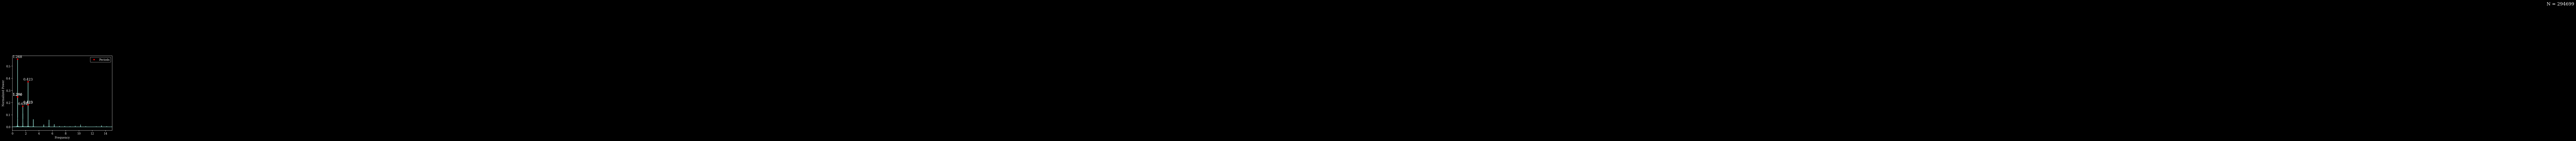

In [ ]:
peak_freqs = [frequency[i] for i in peak_ind]
peak_periods = [periods[i] for i in peak_ind]
peak_power = [power[i] for i in peak_ind]

fig = plt.figure()
plt.plot(frequency, power)
plt.plot(peak_freqs,peak_power,'ro',markersize=4.0, label='Periods')
plt.text(max(frequency), 1, 'N = '+str(len(lc_phase_cut)), fontsize=16, ha='center')
for i in peak_ind:
    plt.annotate("{:.3f}".format(periods[i]), (frequency[i], power[i]), textcoords="offset points", xytext=(0,5), fontsize=12, ha='center')
plt.xlabel('Frequency')
plt.ylabel('Normalized Power')
plt.xlim([0,15])
plt.legend()
plt.show()

The above plot is the output of running the periodogram on full light curve, omitting all eclipses. The x-axis shows the frequencies $\omega$ and the y-axis is the normalized power that is a measurement of the least squares fit where 1 is a perfect fit. We see a few noticable spikes that are labeled with the red dots labeled with the period in days that matched the frequency. The main spike matches the orbital period so we have sucessfully confirmed the orbital period. The second spike is the first harmonic of the orbital period and is not a surprising spike to see. We can also see a third spike larger even then the second that is also interesting. I am unsure what exactly this period of 0.423 days would align with physically. It is 1/3 of the orbital period so maybe it is related to the 3-body system present.

# Recreating Figure 9 from Martin et. al. 2024

Figure 9 from Martin et. al. 2024 shows the flares where the peak of the flare occurs within a primary or secondary eclipse.

To recreate this plot, we first need to mark off the exact times of all flares that occur during a primary or secondary eclipse.

In [ ]:
# arrays to store the specific times of the flares that occur during
# primary or secondary eclipses
flare_time_primary = []
flare_time_secondary = []

# looping through all the flares to test whether they occur during the right phase
for time in flare_time:
  flare_ind = np.where(flare_time == time)[0]
  lc_ind = np.where(lc_time == time)[0]
  if len(flare_ind)!=0:
    if lc_phase[lc_ind[0]]<.27 and lc_phase[lc_ind[0]] >.23 and time not in flare_time_primary:
      flare_time_primary.append(time)
    if lc_phase[lc_ind[0]]>.73 and lc_phase[lc_ind[0]] <.77 and time not in flare_time_secondary:
      flare_time_secondary.append(time)

Next, we need to be able to subtract out the light curve flux from the eclipses, so we can better view the flares. Looking at the plot below, we can see how difficult it is to visually recognize the flare that occurs within the dip of a primary eclipse.

Text(0.5, 0, 'Time')

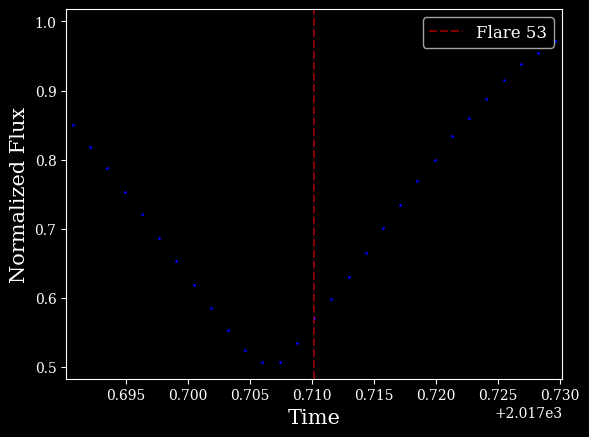

In [ ]:
# select the a random flare that occurs during a primary eclipse
# flare 127, at position 6 in the flare_time_primary, is a good one to use
ind = np.random.randint(len(flare_time_primary))
# set lower and upper time bounds that correlate to lower and upper indeces
# for looking at the other arrays (like flux or phase)
lower = flare_time_primary[ind] - .05
higher = flare_time_primary[ind] + .05
l_ind = np.argmin(np.abs(lc_time - lower))
h_ind = np.argmin(np.abs(lc_time - higher))

# plotting the light curve across the timeframe of interest
plt.scatter(lc_time[l_ind:h_ind], np.array(lc_flux[l_ind:h_ind]),s=1,color='blue')
# plotting the vertical line at the exact time of the flare to mark off where
# we should see a jump in flux
plt.axvline(flare_time_primary[ind], ls = '--', color = 'red', label = 'Flare ' + str(np.where(flare_time == flare_time_primary[ind])[0][0]), alpha = 0.5)

#setting the x limits to zoom in
plt.xlim(flare_time_primary[ind]-.02, flare_time_primary[ind]+.02)
plt.legend(fontsize = 12)
plt.ylabel('Normalized Flux', fontsize = 15)
plt.xlabel('Time', fontsize = 15)

We can see that it's hard to recognize a flare that jumps off from the downsloping normalized flux line that occurs during an eclipse, primary or secondary.

To fix this problem, we can use the scipy.optimize.curve_fit function to fit a curve modelling the shapes of primary or secondary eclipses in flux space and subtracting those models out.

We chose to fit the eclipse curves with a quartic function, but perhaps another setup works better! For preliminary analysis, this choice works sufficiently.

In [ ]:
# defining the function we will use to fit our fluxes
def func(x,  a, b, c, d, e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

curve_fit_phases_primary = []
curve_fit_fluxes_primary = []
curve_fit_phases_secondary = []
curve_fit_fluxes_secondary = []
# this collects all the fluxes within our primary and secondary eclipse bounds
# these bounds are phases between .23 and .27 for primary eclipses,
# and between .73 and .77 for secondary.
for i in range(len(lc_phase)):
    if lc_phase[i]>=.23 and lc_phase[i]<=.27 and lc_phase[i] not in curve_fit_phases_primary:
        curve_fit_phases_primary.append(lc_phase[i])
        curve_fit_fluxes_primary.append(lc_flux[i])
    if lc_phase[i]>=.73 and lc_phase[i]<=.77 and lc_phase[i] not in curve_fit_phases_secondary:
        curve_fit_phases_secondary.append(lc_phase[i])
        curve_fit_fluxes_secondary.append(lc_flux[i])

# these lines of code use the scipy.optimize.curve_fit method to fit
# the fluxes of the primary and secondary eclipses to the phases with the func model
prim_popt, prim_popc = scipy.optimize.curve_fit(func, curve_fit_phases_primary, curve_fit_fluxes_primary)
sec_popt, sec_popc = scipy.optimize.curve_fit(func, curve_fit_phases_secondary, curve_fit_fluxes_secondary)


Now that we've fit our data, we can do a sanity test to see how well the fit worked by plotting the orginal phase vs. flux data and the curve fit model on the same graph!

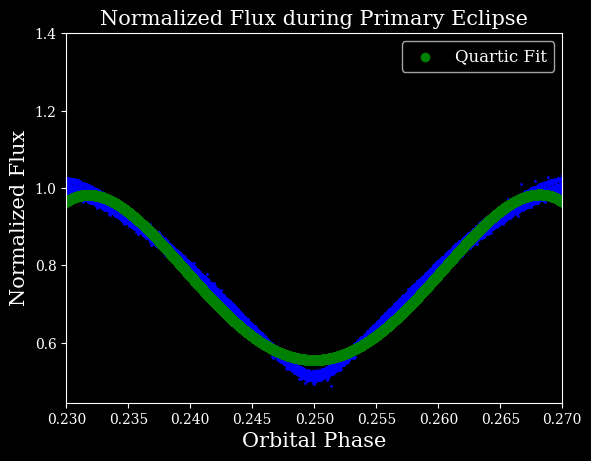

In [ ]:
fig = plt.figure()
x = np.array(curve_fit_phases_primary)
plt.scatter(lc_phase, lc_flux,s=1,color='blue')
plt.scatter(x, prim_popt[0]*x**4 + prim_popt[1]*x**3 + prim_popt[2]*x**2 + prim_popt[3]*x + prim_popt[4], color = 'green', label = 'Quartic Fit')
plt.legend(fontsize = 12)
plt.title('Normalized Flux during Primary Eclipse', fontsize = 15)
plt.xlabel('Orbital Phase', fontsize = 15)
plt.ylabel('Normalized Flux', fontsize = 15)
plt.xlim([.23, .27])
plt.show(block=False)

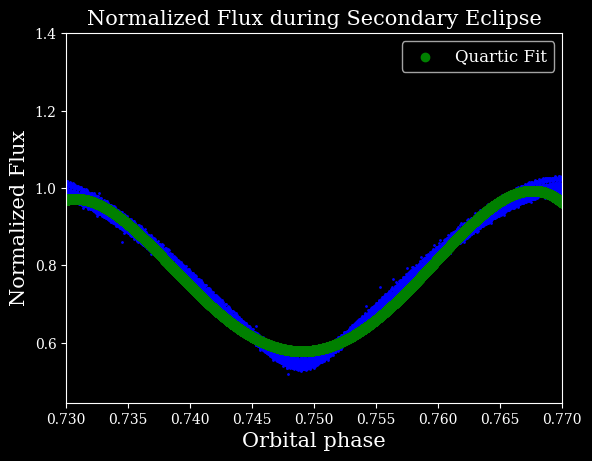

In [ ]:
fig = plt.figure()
x = np.array(curve_fit_phases_secondary)
plt.scatter(lc_phase, lc_flux,s=1,color='blue')
plt.scatter(x, sec_popt[0]*x**4 + sec_popt[1]*x**3 + sec_popt[2]*x**2 + sec_popt[3]*x + sec_popt[4], color = 'green', label = 'Quartic Fit')
plt.legend(fontsize = 12)
plt.title('Normalized Flux during Secondary Eclipse', fontsize = 15)
plt.xlabel('Orbital phase', fontsize = 15)
plt.ylabel('Normalized Flux', fontsize = 15)
plt.xlim([.73, .77])
plt.show(block=False)

Visually, we can see that the quartic function fits our data well! While for the primary eclipses it seems to miss that low dip right at the base of the eclipse, it overall looks like something we can base our further analysis on. The fit for the secondary eclipses seems to more closely match that final dip as well.

With those two steps handled, we can plot each individual flare that occurs during a primary or secondary eclipse. We can subtract out our curve fit from our light curves, and then we can better see the jump caused by the solar flares.

Here are the plots of the light curves around the time of the 10 identified to have occured during a primary eclipse (happening between a phase of .23 and .27):

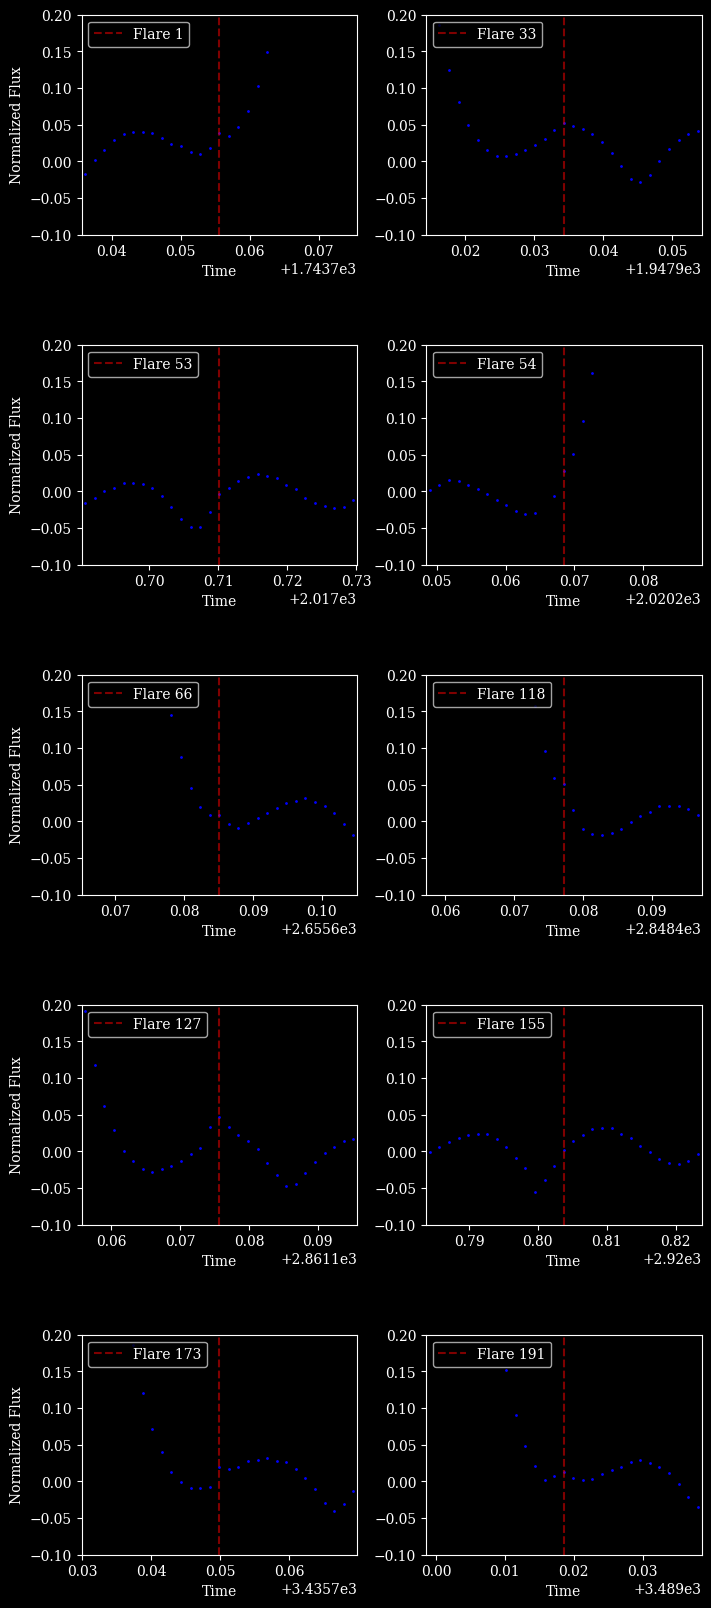

In [ ]:
# plotting all 10 primary eclipses with the eclipse subtracted out
fig, axs = plt.subplots(5, 2)
fig.set_size_inches(8, 20)
fig.subplots_adjust(wspace=.25, hspace=.5)

k = 0
for j in range(5):
    axs[j][0].set_ylabel('Normalized Flux')
    for i in range(2):
        lower = flare_time_primary[k] - .05
        higher = flare_time_primary[k] + .05
        l_ind = np.argmin(np.abs(lc_time - lower))
        h_ind = np.argmin(np.abs(lc_time - higher))
        x = np.array(lc_phase[l_ind:h_ind])
        axs[j][i].scatter(lc_time[l_ind:h_ind], np.array(lc_flux[l_ind:h_ind]) - (prim_popt[0]*x**4 + prim_popt[1]*x**3 + prim_popt[2]*x**2 + prim_popt[3]*x + prim_popt[4]) ,s=1,color='blue')
        axs[j][i].axvline(flare_time_primary[k], ls = '--', color = 'red', label = 'Flare ' + str(np.where(flare_time == flare_time_primary[k])[0][0]), alpha = 0.5)
        axs[j][i].legend(loc = 'upper left')
        axs[j][i].set_xlim(flare_time_primary[k]-.02, flare_time_primary[k]+.02)
        axs[j][i].set_ylim(-.1, .2)
        k+=1
        axs[j][i].set_xlabel('Time')

And below are the plots of the light curves around the time of the 10 identified to have occured during a secondary eclipse (happening between a phase of .73 and .77). We split them up into 2 distinct cells due to the limitations of google colab, so they are more easily viewable.

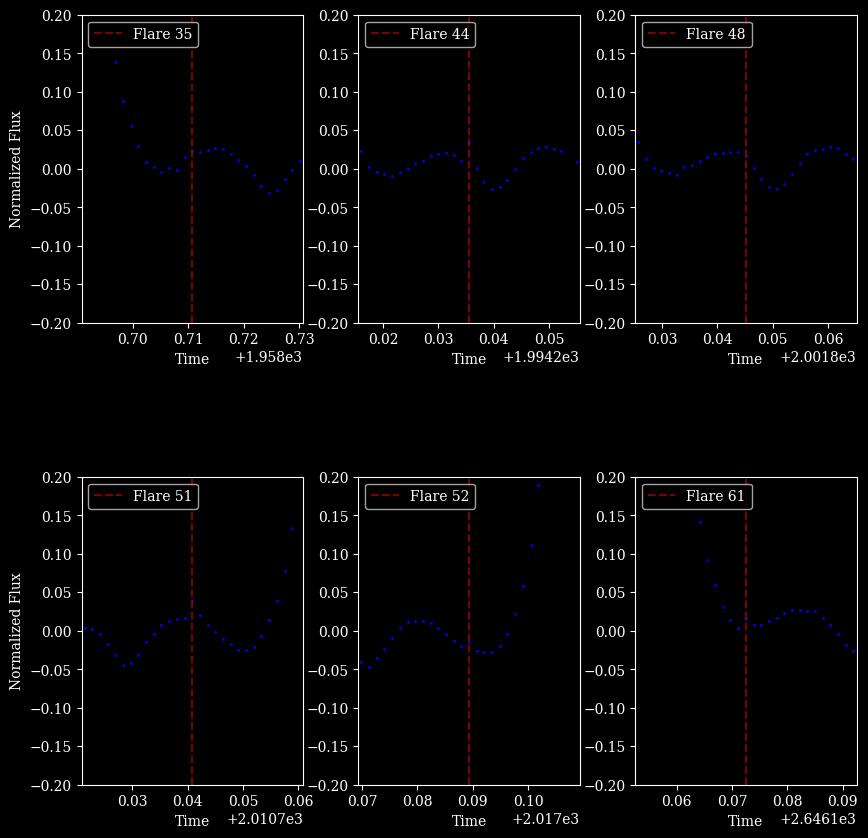

In [ ]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(10, 10)
fig.subplots_adjust(wspace=.25, hspace=.5)

k=0
for j in range(2):
    axs[j][0].set_ylabel('Normalized Flux')
    for i in range(3):
        lower = flare_time_secondary[k] - .05
        higher = flare_time_secondary[k] + .05
        l_ind = np.argmin(np.abs(lc_time - lower))
        h_ind = np.argmin(np.abs(lc_time - higher))
        x = np.array(lc_phase[l_ind:h_ind])
        axs[j][i].scatter(lc_time[l_ind:h_ind], np.array(lc_flux[l_ind:h_ind]) - (sec_popt[0]*x**4 + sec_popt[1]*x**3 + sec_popt[2]*x**2 + sec_popt[3]*x + sec_popt[4]) ,s=1,color='blue')
        axs[j][i].set_xlim(flare_time_secondary[k]-.02, flare_time_secondary[k] +.02)
        axs[j][i].axvline(flare_time_secondary[k], ls = '--', color = 'red', label = 'Flare ' + str(np.where(flare_time == flare_time_secondary[k])[0][0]), alpha = 0.5)
        axs[j][i].set_ylim(-.2, .2)
        axs[j][i].legend(loc = 'upper left')
        axs[j][i].set_xlabel('Time')
        k+=1

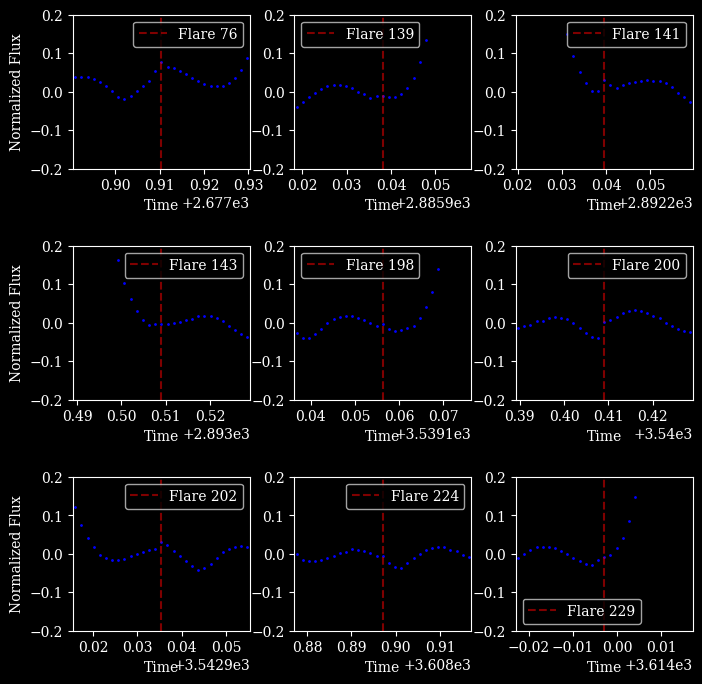

In [ ]:
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(8, 8)
fig.subplots_adjust(wspace=.25, hspace=.5)

for j in range(3):
    axs[j][0].set_ylabel('Normalized Flux')
    for i in range(3):
        lower = flare_time_secondary[k] - .05
        higher = flare_time_secondary[k] + .05
        l_ind = np.argmin(np.abs(lc_time - lower))
        h_ind = np.argmin(np.abs(lc_time - higher))
        x = np.array(lc_phase[l_ind:h_ind])
        axs[j][i].scatter(lc_time[l_ind:h_ind], np.array(lc_flux[l_ind:h_ind]) - (sec_popt[0]*x**4 + sec_popt[1]*x**3 + sec_popt[2]*x**2 + sec_popt[3]*x + sec_popt[4]) ,s=1,color='blue')
        axs[j][i].set_xlim(flare_time_secondary[k]-.02, flare_time_secondary[k] +.02)
        axs[j][i].axvline(flare_time_secondary[k], ls = '--', color = 'red', label = 'Flare ' + str(np.where(flare_time == flare_time_secondary[k])[0][0]), alpha = 0.5)
        axs[j][i].set_ylim(-.2, .2)
        axs[j][i].legend()
        axs[j][i].set_xlabel('Time')
        k+=1

Evidently, the quartic curve fitting does not allow us to perfectly subtract out the dip from the eclipses. However, we argue that it still much more easily allows us to see the flare in many of the primary/secondary cases (see flares 202, 229, and 200 above for some good examples of secondary eclipse flares)!

Take flare 66, which occurs during a primary eclipse:

Text(0, 0.5, 'Corrected Flux')

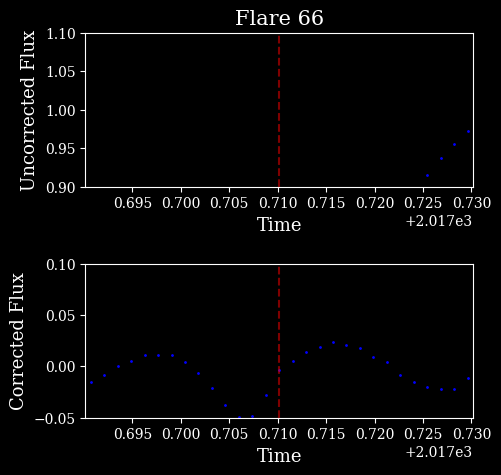

In [ ]:
fig, axs = plt.subplots(2)
fig.subplots_adjust(wspace=.25, hspace=.5)
fig.set_size_inches(5, 5)

k=2
lower = flare_time_primary[k] - .05
higher = flare_time_primary[k] + .05
l_ind = np.argmin(np.abs(lc_time - lower))
h_ind = np.argmin(np.abs(lc_time - higher))
x = np.array(lc_phase[l_ind:h_ind])
axs[0].scatter(lc_time[l_ind:h_ind], np.array(lc_flux[l_ind:h_ind]) ,s=1,color='blue')
axs[0].axvline(flare_time_primary[k], ls = '--', color = 'red', label = 'Flare ' + str(np.where(flare_time == flare_time_primary[k])[0][0]), alpha = 0.5)
axs[0].set_xlim(flare_time_primary[k]-.02, flare_time_primary[k]+.02)
axs[0].set_ylim(.9, 1.1)
axs[0].set_xlabel('Time', fontsize = 13)
axs[0].set_ylabel('Uncorrected Flux', fontsize = 13)
axs[0].set_title('Flare 66', fontsize = 15)

axs[1].scatter(lc_time[l_ind:h_ind], np.array(lc_flux[l_ind:h_ind]) - (prim_popt[0]*x**4 + prim_popt[1]*x**3 + prim_popt[2]*x**2 + prim_popt[3]*x + prim_popt[4]) ,s=1,color='blue')
axs[1].axvline(flare_time_primary[k], ls = '--', color = 'red', label = 'Flare ' + str(np.where(flare_time == flare_time_primary[k])[0][0]), alpha = 0.5)
axs[1].set_xlim(flare_time_primary[k]-.02, flare_time_primary[k]+.02)
axs[1].set_ylim(-.05, .1)
axs[1].set_xlabel('Time', fontsize = 13)
axs[1].set_ylabel('Corrected Flux', fontsize = 13)

As opposed to earlier, we barely recognize the change in the slope of the light curve, when looking at our corrected flux we see a clear bump up above the point before. Again, although the correction isn't perfect, we can still on average better perceive the impact the flares have on the light curves during the eclipses. For further analysis, the priority would be determining a better function with which to fit the light curve during eclipses (or perhaps using a Fourier transform).

#Conclusion and Summary

What are the key takeaways of our analysis?


1.   Spot modulation flux is correlated with flare occurrence;flares happen more frequently when the spot modulation flux is positive, or the star is overall brighter on average.
2.   Spot modulation flux is not correlated with flare amplitude or flare energy.
3.   The orbital phase of CM Draconis seems to impact the flare occurence rate, but not necessarily in the way we (or Martin et. al. 2024) expect. It seems that eclipses, primary or secondary, do not lead to fewer overall flares.
4.   However, similarly to the spot modulation flux, there is no correlation between the orbital phase of CM Draconis and either the flare amplitude or flare energy.
5.   Using the periodogram, we were able to verify the orbital period and found a strong fit at a period of 0.423 days, which could indicate some other periodic cycle within the system. It may be tied to the 3rd body, stellar rotation, the flares, or simply a strong harmonic of the orbital period.

6.   A quartic function can be used to model the light curve during primary and secondary eclipses as a tool for a preliminary inspection of flares occuring during those phases.



Ultimately, we hope you can now come away from this notebook with a better understnading of eclipsing binary star systems, the data we get from them on Earth, and how we can work with this data.